# Eighth Session, Notebook # 13: Introduction to Gaussian Processes

## Today's agenda:
0. __Workshop Overview__:
    * __When__: August 23rd  1pm-5pm<!---*insert day* from *insert time range*--->
    * __Where__: CUNY Graduate Center <!---*insert room number--->
    * __What__: Today we will be learning about Gaussian Processes!
    * __Want__ to lead a session for a topic? Some Days there will be small hack sessions for people to discuss problems they're working on.
    * __Online Resources__:  __https://daxfeliz.github.io/cunybridgebootcamp/__
    * __Program Schedule__: __https://tinyurl.com/4r35txe2__   
&nbsp;

1. __This session__:
* Learning about the statistics behind Gaussian Processes (GP)
* Learning how to apply GPs for fitting data

</br>
&nbsp;

2. __Next session__:
    * Programming Project and/or Open Hack Session
    * __Make sure you bring your laptop to this session and future sessions__.


## A standard intro to a new modeling technique is to start with fitting a line to some data.


To start, we’ll generate some fake data using a linear model. Feel free to change the random number seed to try out a different dataset.

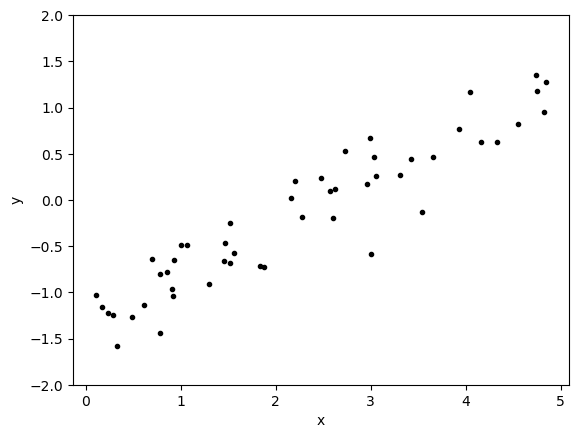

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

true_m = 0.5 # slope
true_b = -1.3 #y-intercept
true_logs = np.log(0.3) #log uncertainty 

x = np.sort(np.random.uniform(0, 5, 50))
y = true_b + true_m * x + np.exp(true_logs) * np.random.randn(len(x))
yerr = np.ones_like(y)*np.nanstd(y)

plt.plot(x, y, ".k")
plt.ylim(-2, 2)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

# To give some mathy language to describe this data set, we can start by describing a model as:

## a function of x described by parameters ($\theta$) = f(t;$\theta$). 
In the case of a straight line model, $\theta$ : m,b \& $\sigma$ (where $\sigma$ is the uncertainty).

# If we assume that our data has "white noise", meaning our data has no correlation from one data point to the next, we can approximate that our data points can be described with a normal distribution:

## Y$_N$ = $\mathcal{N}(\mu, \sigma_N^{2})$ where $\mu$ (or mean) = f(t$_N$;$\theta$). 

### So what is the probability (or "likelihood") of a data point (Y$_N$) being described by a set of parameters ($\theta$)?

## p(Y$_N$ | $\theta$) = $\Pi_{n=0}^{n=N} \frac{1}{\sqrt{2\pi\sigma_n^2}}~\rm{exp} \big[ -\frac{1}{2}\frac{ (Y_n - f(t_n ; \theta))^2}{ \sigma_n^{2}} \big] $

* where $\Pi_{n=0}^{n=N}$ is the product operator from n=0 to n=N
* and the formula inside the product operator is the [__equation for a gaussian fucntion__](https://en.wikipedia.org/wiki/Gaussian_function)

### To get the "log-likelihood", we take the log of both sides and our equation becomes:

## ln$\big($ p(Y$_N$ | $\theta) \big)$ = $\Sigma_{n=0}^{n=N} -\frac{1}{2}\frac{ (Y_n - f(t_n ; \theta))^2}{ \sigma_n^{2}} - \frac{1}{2}ln(2\pi\sigma_n^{2})   $

### where $\frac{ (Y_n - f(t_n ; \theta))^2}{ \sigma_n^{2}}$ is basically the equation for $\chi^2$ as we saw in the previous session ([Session 7](https://github.com/daxfeliz/cunybridgebootcamp/blob/main/current_and_past_sites/2023_notebooks/Session_07/12_Statistics_Training.ipynb)) and $\frac{1}{2}ln(2\pi\sigma_n^{2})$ is a constant (also referred to as a normalization factor).

## In Session 7, our goal was to minimize our $\chi^2$ measurements to find a model $\big(f(t_N ; \theta)\big)$ that fits the data best. Similarly, we want to maximize the log-likelihood to find a model with the highest probability of fitting our data.


### __Caveat__: Real data won't always have **only** white noise. Sometimes there are real correlations in our data that can come from instrumental effects, data collection strategies or physical trends from the source of observations. Some folks like to account for this by adding a "jitter" term where they replace $\sigma_n^{2}$ with $\big(\sigma_n^{2} + S^2\big)$ where S is a shared parameter for every data point. This modification, results in a high probabilistic model with smaller uncertainties. It's not a bad idea to always have a jitter term.

# So, what is a Gaussian Process and how do we do it?

## To set up what is a Gaussian Process, we first need to discuss some definitions and operations.


### A common practice whenever fitting models to data is to take the residuals (data - model) & calculate the covariance function which is how much two random variables (ex: $Y_1(x)$, $Y_2(x)$) change together (their covariance) with varying separation in x. The covariance function can be defined as:

## Cov(y$_1$,y$_2$) = $\overline{\big[ (y_1-\overline{y_1}) \big] \big[ (y_2-\overline{y_2}) \big]}$

### In Linear Algebra notation, we can describe the residuals as a vector such as:
\begin{align}
\vec{r} &= \begin{bmatrix}
       Y_{1} - f(t_1;\theta)  \\
       \vdots & \\
       Y_{N} - f(t_N;\theta) 
     \end{bmatrix}
\end{align}

### and our covariance, like so:
\begin{align}
\vec{C} &= \begin{bmatrix}
       \sigma_1^2 & \cdots & 0 \\
       0 & \cdots & 0 \\
       \vdots & \ddots & \vdots \\
       0 & \cdots & 0 \\
       0 & \cdots & \sigma_n^2
     \end{bmatrix}
  \end{align}

### In this notation, our log-likelihood can then be described as:

## ln$\big( p(Y_N | \theta) \big)$ = $-\frac{1}{2}~\vec{r}^{T}~\vec{C}^{-1}~\vec{r} - \frac{1}{2}ln|2\pi \vec{C}|$
### where $\vec{r}^T$ is the transpose of the $\vec{r}$ vector, $\vec{C}^{-1}$ is the inverse of the $\vec{C}$ vector.

# So with all that said, what is a Gaussian Process (GP)? A GP in its most basic terms, adds non-zero off-diagonal elements to $\vec{C}$ to effectively model the data. How we do that is by using a function denoted by $C_{nm}$ or sometimes its' denoted by ${K_{nm}$ for reasons we'll discuss in a minute.

## $C_{nm}$ = $K_{nm}$ = $\kappa(x_N,x_m; \alpha) + \delta_{nm}\sigma_N^2$ 
### where $\kappa(x_N,x_m; \alpha)$ are the off-diagonal elements of the covariance matrix (also called a Kernal, hence the K notation) and $\delta_{nm}\sigma_N^2$ is our diagonal matrix ($\vec{C}$) shown above.

## So then, the log-likelihood of our GP model which is described by $\theta$ and $\alpha$ parameters becomes:

## $ln\big( p(Y_N | \theta, \alpha) \big)$ = $-\frac{1}{2}\vec{r_{\theta}}^{T}\vec{K_{\alpha}}^{-1}\vec{r_{\theta}} -\frac{1}{2}ln(2\pi K_{\alpha})$

### where $\vec{r_{\theta}}$ depends on $\theta$ and $\vec{K_{\alpha}}$ depends on $\alpha$.

# Example kernel #1:

## $K_{DRW}( | t_n - t_m| ; \alpha)$ = $a^2~\rm{exp} \big[ -\frac{|t_n-t_m|}{\ell} \big]$
### where DRW stands for damped random walk ; a has units of y and $\ell$ has units of x. These are called "hyper parameters".
This is sometimes referred to as a "exponential kernel".

# Example kernel #2:

## $K_{sq~exp}( | t_n - t_m| ; \alpha)$ = $a^2~\rm{exp} \big[ -\frac{|t_n-t_m|^2}{\ell^2} \big]$
### This is referred to as a "squared exponential kernel". The purpose of squaring the exponetial term. The advantage of using this kernel is that is good for modeling smooth functions that may not be continuous (meaning missing data). The exponential kernel may not fit data sets with missing data as well.


# Example kernel #3:

## $K_{per}( | t_n - t_m| ; \alpha)$ = $a^2~\rm{cos} \big[ -\frac{2\pi|t_n-t_m|}{\ell} \big]$
### This is referred to as a "periodic kernel". The advantage of using this kernel is that is good for modeling data with periodic variability.

### Once you've chosen a kernel that seems appropriate for your data, you need to construct a "Kernel Function" which will be used to produce a GP model of your data.

### Say you have a dataset which displays dampened variability and a periodic signal. An appropriate assumption would be to use a combination of all three of these kernels, like so:

## $K$ = $K_{sq~exp} \times K_{per} + K_{DRW}$

Once this Kernel function (K) is defined, we need to apply a MCMC (See [Session 7](https://github.com/daxfeliz/cunybridgebootcamp/blob/main/current_and_past_sites/2023_notebooks/Session_07/12_Statistics_Training.ipynb)) to find the most probable combination for our model parameters ($\theta$) hyper parameters ($\alpha$).


### For more kernel examples, see [https://www.cs.toronto.edu/~duvenaud/cookbook/](https://www.cs.toronto.edu/~duvenaud/cookbook/)





# Back to fitting a straight line with a GP

## We can use PyMC3 to model a straight line. 

### To begin, let's install PyMC3 with this command in our Terminals:
```bash
conda install -c conda-forge pymc3 arviz
```
and after that, we'll then install some external tools:
```bash
pip install pymc3-ext
```

### Once, it's installed we can create a PyMC3 model and define the bounds of the distributions that describe our model and hyper parameters. In this case, our model parameters are $m$ and $b$ and our hyper parameter is $\sigma$. As we construct our model, we can provide strings as nicknames for each parameter that gets stored in the model object. In the end, to store all of our sampling of the parameter space for our hyper parameters (our MCMC fitting), we store it in a trace object.


## Another package we'll use for Kernel function construction is Celerite 2. There are a number of other packages to construct Kernel functions with (see [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.Kernel.html#sklearn.gaussian_process.kernels.Kernel), )but I've had most luck with Celerite 2. To install this, enter this command in your Terminal:

```bash
python -m pip install -U celerite2
```

In [2]:
import pymc3 as pm
import pymc3_ext as pmx
draws=500
tunes=500
prior_sigma=2.0

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0.0, sigma=prior_sigma)
    log_jitter = pm.Normal("log_jitter", mu=0.0, sigma=prior_sigma)

    # Define the priors on each parameter:
    m = pm.Uniform("m", lower=-5, upper=5)
    b = pm.Uniform("b", lower=-5, upper=5)
    logs = pm.Uniform("logs", lower=-5, upper=5)

    # Define the likelihood. A few comments:
    #  1. For mathematical operations like "exp", you can't use
    #     numpy. Instead, use the mathematical operations defined
    #     in "pm.math".
    #  2. To condition on data, you use the "observed" keyword
    #     argument to any distribution. In this case, we want to
    #     use the "Normal" distribution (look up the docs for
    #     this).
    liklihood = pm.Normal("obs", mu=m * x + b, sd=pm.math.exp(logs), observed=y)

    # find Maximum a Priori model (meaning after applying bounds for hyper parameter distribution)
    # this is a like a first guess model
    map_soln =  pm.find_MAP(model=model)
    
    # This is how you will sample the model. Take a look at the
    # docs to see that other parameters that are available.
    # trace = pm.sample(draws=draws, tune=tunes, chains=2, cores=2)
    trace = pmx.sample(tune=tunes, draws=draws, start=map_soln,
                       cores=2,chains=2,return_inferencedata=True )          


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logs, b, m, log_jitter, mean]


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 1 seconds.


# To visualize our trace object, we need to use "Arviz" to view the samples for each of our chains: 

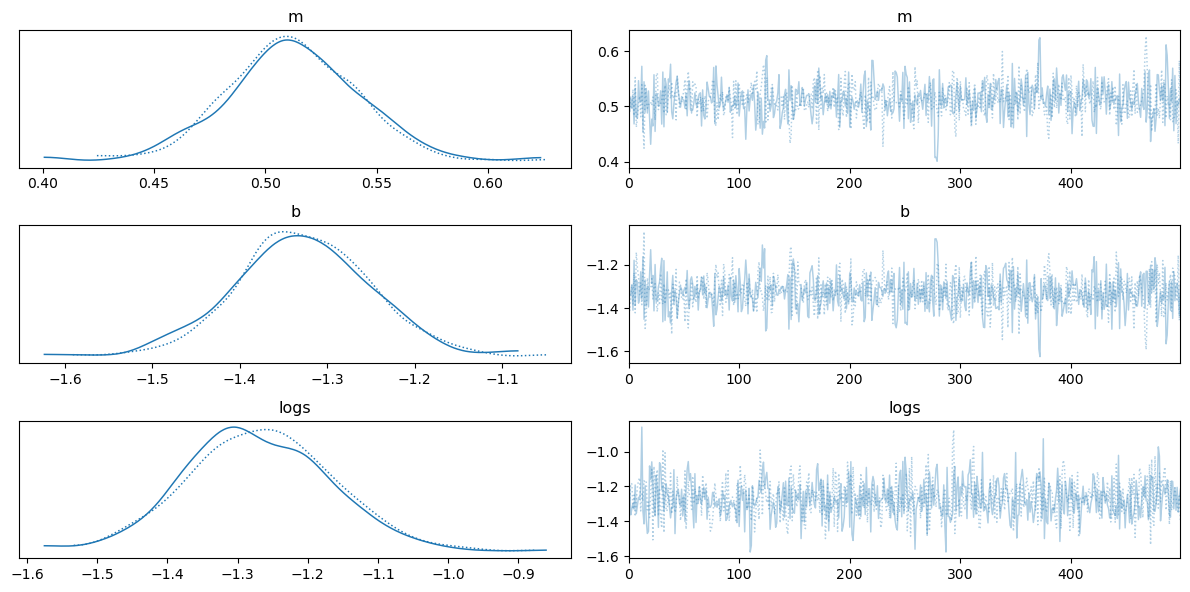

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
m,0.512,0.030,0.458,0.567,0.001,0.001,1025.0,747.0,1.0
b,-1.328,0.077,-1.474,-1.184,0.002,0.002,1055.0,779.0,1.0
logs,-1.269,0.103,-1.461,-1.078,0.003,0.002,1051.0,882.0,1.0


In [3]:
import arviz as az
with model:
    az.plot_trace(trace, var_names=["m", "b", "logs"])
    plt.tight_layout(pad=1)
    plt.show()
    summary = az.summary(trace, var_names=["m", "b", "logs"])
summary

# Another useful visual is to use something called a "[__Corner__](https://corner.readthedocs.io)" plot which shows 2D histograms of different combinations of our model and hyper parameters. A 2D gaussian will look like a circle. If our 2D histograms appear circle-ish, then we likely have a pretty good fit!

## To install corner, enter this command in your Terminal
```bash
conda install -c corner
```


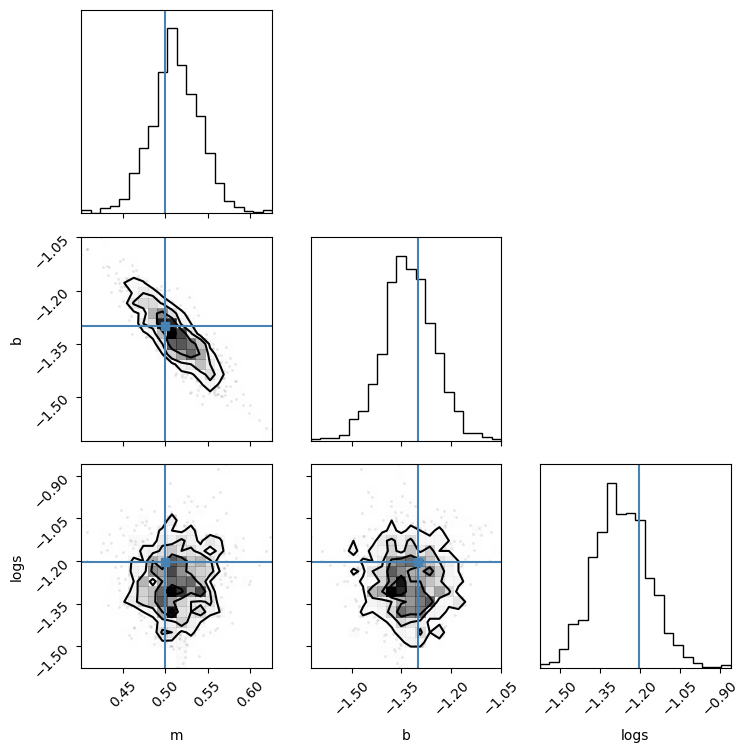

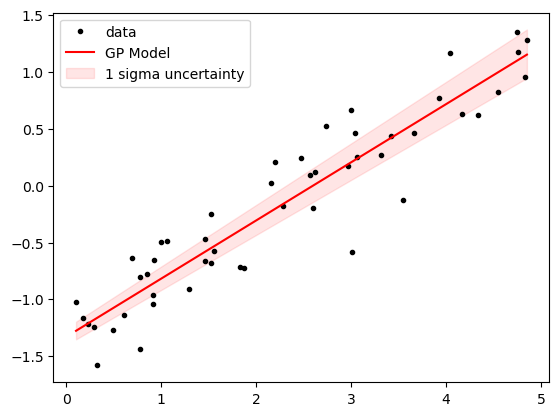

In [4]:
import corner  # https://corner.readthedocs.io

names = ["m", "b", "logs"]
_ = corner.corner(
    trace,
    var_names=names,
    truths=dict(zip(names, [true_m, true_b, true_logs])),
)
plt.tight_layout(pad=1)
plt.show()

mcmc_m=np.asarray(trace.posterior["m"]).flatten()
mcmc_b=np.asarray(trace.posterior["b"]).flatten()
mcmc_sig=np.asarray(trace.posterior["logs"]).flatten()

mcmc_m_16th_percentile = np.percentile(mcmc_m,[16],axis=-1)
mcmc_m_50th_percentile = np.percentile(mcmc_m,[50],axis=-1)
mcmc_m_84th_percentile = np.percentile(mcmc_m,[84],axis=-1)

mcmc_b_16th_percentile = np.percentile(mcmc_b,[16],axis=-1)
mcmc_b_50th_percentile = np.percentile(mcmc_b,[50],axis=-1)
mcmc_b_84th_percentile = np.percentile(mcmc_b,[84],axis=-1)

mcmc_sig_16th_percentile = np.percentile(mcmc_sig,[16],axis=-1)
mcmc_sig_50th_percentile = np.percentile(mcmc_sig,[50],axis=-1)
mcmc_sig_84th_percentile = np.percentile(mcmc_sig,[84],axis=-1)

mcmc_y16 = mcmc_b_16th_percentile + mcmc_m_16th_percentile * x #+ np.exp(mcmc_sig_16th_percentile)
mcmc_y50 = mcmc_b_50th_percentile + mcmc_m_50th_percentile * x #+ np.exp(mcmc_sig_50th_percentile)
mcmc_y84 = mcmc_b_84th_percentile + mcmc_m_84th_percentile * x #+ np.exp(mcmc_sig_84th_percentile)

plt.plot(x,y,'k.',label="data")
plt.plot(x,mcmc_y50,'r-', label="GP Model")
plt.fill_between(x,y1=mcmc_y16,y2=mcmc_y84,label='1 sigma uncertainty',color='red',alpha=0.1)
plt.legend()
plt.show()


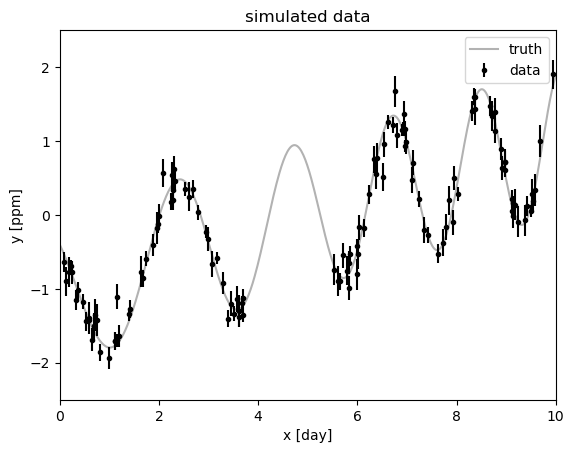

In [5]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

t = np.sort(
    np.append(
        np.random.uniform(0, 3.8, 57),
        np.random.uniform(5.5, 10, 68),
    )
)  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * np.random.randn(len(t))
)

true_t = np.linspace(0, 10, 500)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3,label='truth')
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0,label='data')
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
plt.title("simulated data")
plt.legend()
plt.show()

In [6]:
np.shape(t),np.shape(true_t),np.shape(y)

((125,), (500,), (125,))

In [7]:
import celerite2
from celerite2 import terms

# Quasi-periodic term
term1 = terms.SHOTerm(sigma=1.0, rho=1.0, tau=10.0)

# Non-periodic component
term2 = terms.SHOTerm(sigma=1.0, rho=5.0, Q=0.25)
kernel = term1 + term2

# Setup the GP
gp = celerite2.GaussianProcess(kernel, mean=0.0)
gp.compute(t, yerr=yerr)

print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -16.751640798326306


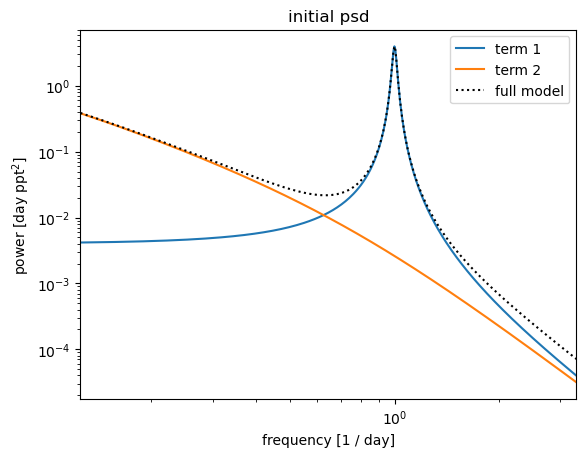

In [8]:
freq = np.linspace(1.0 / 8, 1.0 / 0.3, 500)
omega = 2 * np.pi * freq


def plot_psd(gp):
    for n, term in enumerate(gp.kernel.terms):
        plt.loglog(freq, term.get_psd(omega), label="term {0}".format(n + 1))
    plt.loglog(freq, gp.kernel.get_psd(omega), ":k", label="full model")
    plt.xlim(freq.min(), freq.max())
    plt.legend()
    plt.xlabel("frequency [1 / day]")
    plt.ylabel("power [day ppt$^2$]")


plt.title("initial psd")
plot_psd(gp)

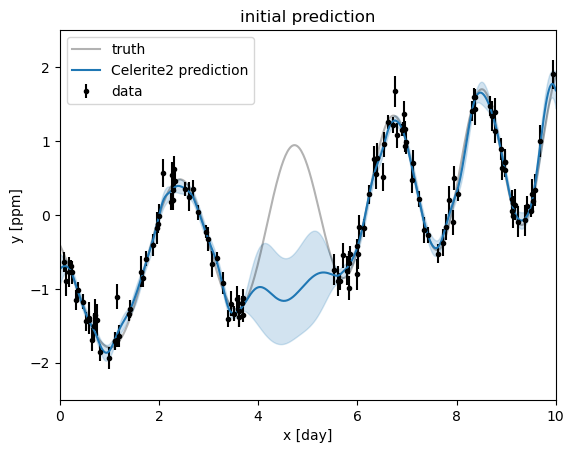

In [9]:
def plot_prediction(gp):
    plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3, label="truth")
    plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label="data")

    if gp:
        mu, variance = gp.predict(y, t=true_t, return_var=True)
        sigma = np.sqrt(variance)
        plt.plot(true_t, mu, label="Celerite2 prediction")
        plt.fill_between(true_t, mu - sigma, mu + sigma, color="C0", alpha=0.2)

    plt.xlabel("x [day]")
    plt.ylabel("y [ppm]")
    plt.xlim(0, 10)
    plt.ylim(-2.5, 2.5)
    plt.legend()


plt.title("initial prediction")
plot_prediction(gp)

In [10]:
from scipy.optimize import minimize


def set_params(params, gp):
    gp.mean = params[0]
    theta = np.exp(params[1:])
    gp.kernel = terms.SHOTerm(
        sigma=theta[0], rho=theta[1], tau=theta[2]
    ) + terms.SHOTerm(sigma=theta[3], rho=theta[4], Q=0.25)
    gp.compute(t, diag=yerr**2 + theta[5], quiet=True)
    return gp


def neg_log_like(params, gp):
    gp = set_params(params, gp)
    return -gp.log_likelihood(y)


initial_params = [0.0, 0.0, 0.0, np.log(10.0), 0.0, np.log(5.0), np.log(0.01)]
soln = minimize(neg_log_like, initial_params, method="L-BFGS-B", args=(gp,))
opt_gp = set_params(soln.x, gp)
soln

      fun: -15.942826369533222
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.13162821e-05, -2.24531505e-04, -3.95061759e-04,  7.67386159e-05,
        1.81898939e-04, -5.11590773e-05,  4.12114789e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 416
      nit: 46
     njev: 52
   status: 0
  success: True
        x: array([ 4.66065311e-03, -3.41553435e-01,  7.00011036e-01,  1.94360863e+00,
        6.06020259e-01,  3.75565805e+00, -7.87260053e+00])

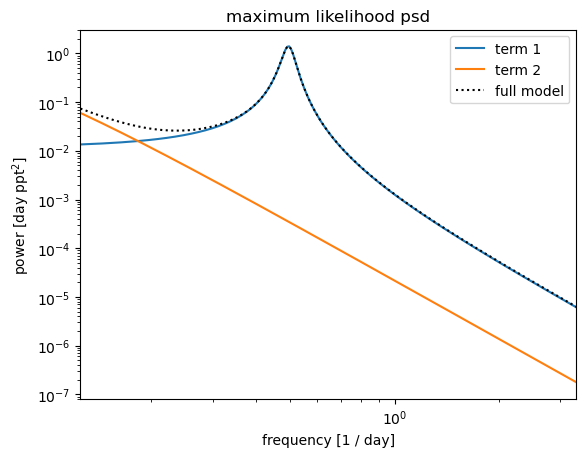

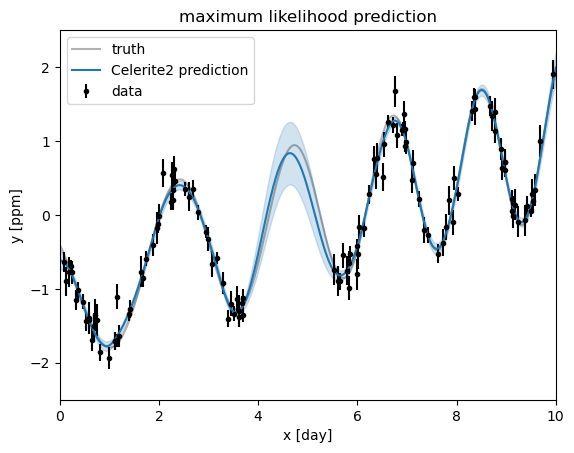

In [11]:
plt.figure()
plt.title("maximum likelihood psd")
plot_psd(opt_gp)

plt.figure()
plt.title("maximum likelihood prediction")
plot_prediction(opt_gp)

In [12]:
prior_sigma = 2.0
tunes=500
draws=500
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    warnings.filterwarnings("ignore", category=RuntimeWarning)

import pymc3 as pm
from celerite2.theano import GaussianProcess, terms as pm_terms 

with pm.Model() as model:
    mean = pm.Normal("mean", mu=0.0, sigma=prior_sigma)
    log_jitter = pm.Normal("log_jitter", mu=0.0, sigma=prior_sigma)

    log_sigma1 = pm.Normal("log_sigma1", mu=0.0, sigma=prior_sigma)
    log_rho1 = pm.Normal("log_rho1", mu=0.0, sigma=prior_sigma)
    log_tau = pm.Normal("log_tau", mu=0.0, sigma=prior_sigma)
    term1 = pm_terms.SHOTerm(
        sigma=pm.math.exp(log_sigma1),
        rho=pm.math.exp(log_rho1),
        tau=pm.math.exp(log_tau) )

    log_sigma2 = pm.Normal("log_sigma2", mu=0.0, sigma=prior_sigma)
    log_rho2 = pm.Normal("log_rho2", mu=0.0, sigma=prior_sigma)
    term2 = pm_terms.SHOTerm(sigma=pm.math.exp(log_sigma2), rho=pm.math.exp(log_rho2), Q=0.25)

    kernel = term1 + term2
    gp = GaussianProcess(kernel, mean=mean)
    
    #covariance function sigma^2 + S^2 
    cov = yerr**2 + pm.math.exp(log_jitter)
    
    gp.compute(t, diag=cov, quiet=True)
    gp.marginal("obs", observed=y)

    pm.Deterministic("psd", kernel.get_psd(omega))
    
    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))
    
    map_soln =  pm.find_MAP(model=model)
    
    

    trace = pmx.sample(
        tune=tunes,
        draws=draws,
        target_accept=0.9,
        init="adapt_full",
        cores=2,
        chains=2,
        random_seed=34923,
        return_inferencedata=True )
    

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [log_rho2, log_sigma2, log_tau, log_rho1, log_sigma1, log_jitter, mean]


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 4 seconds.


57


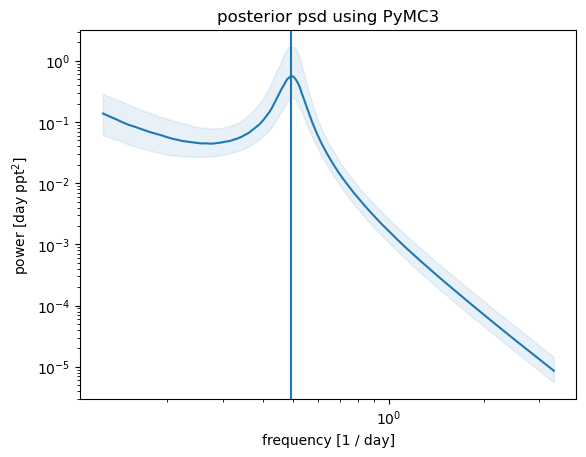

In [13]:
# psds = trace.posterior["psd"].values
flat_samples = trace.posterior.stack(sample=("chain","draw"))
psds=flat_samples['psd']
q= np.percentile(psds,[16,50,84],axis=-1)

plt.loglog(freq, q[1], color="C0")
plt.fill_between(freq, q[0], q[2], color="C0", alpha=0.1)


plt.xlabel("frequency [1 / day]")
plt.ylabel("power [day ppt$^2$]")
_ = plt.title("posterior psd using PyMC3")

max_psd = np.argmax(q[1])
plt.axvline(freq[max_psd])
print(max_psd)


plt.show()

In [14]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

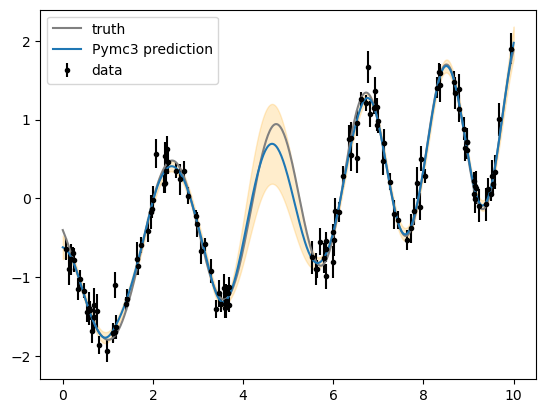

In [15]:
from pymc3_ext import eval_in_model
with model:
    mu, var = eval_in_model(gp.predict(y, t=true_t, return_var=True), map_soln)


plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0,label='data')
sd = np.sqrt(var)
plt.plot(true_t, true_y, label="truth",color='grey')
plt.plot(true_t, mu, label="Pymc3 prediction")
plt.fill_between(true_t, mu - sd, mu + sd, color="orange", alpha=0.2)
plt.legend()
plt.show()

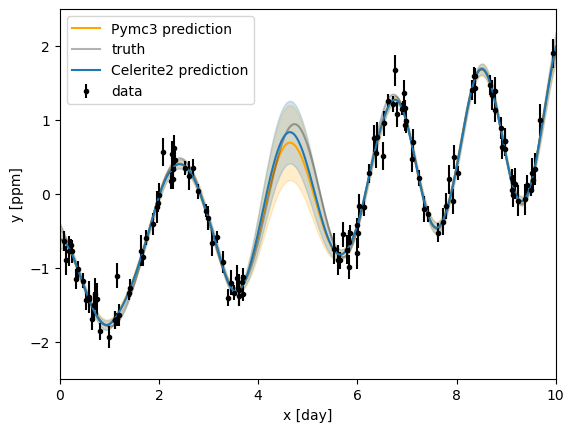

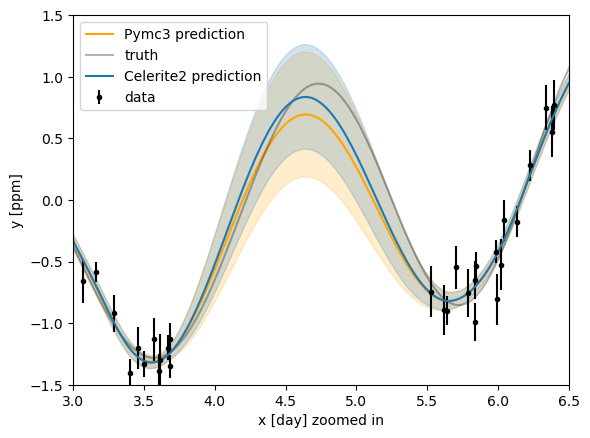

In [16]:
# compare with first method


sd = np.sqrt(var)
plt.plot(true_t, mu, label="Pymc3 prediction",color='orange')
plt.fill_between(true_t, mu - sd, mu + sd, color="orange", alpha=0.2)
plot_prediction(opt_gp)
plt.show()


plt.plot(true_t, mu, label="Pymc3 prediction",color='orange')
plt.fill_between(true_t, mu - sd, mu + sd, color="orange", alpha=0.2)
plot_prediction(opt_gp)
plt.xlim(3,6.5)
plt.ylim(-1.5,1.5)
plt.xlabel('x [day] zoomed in')
plt.show()

In [17]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

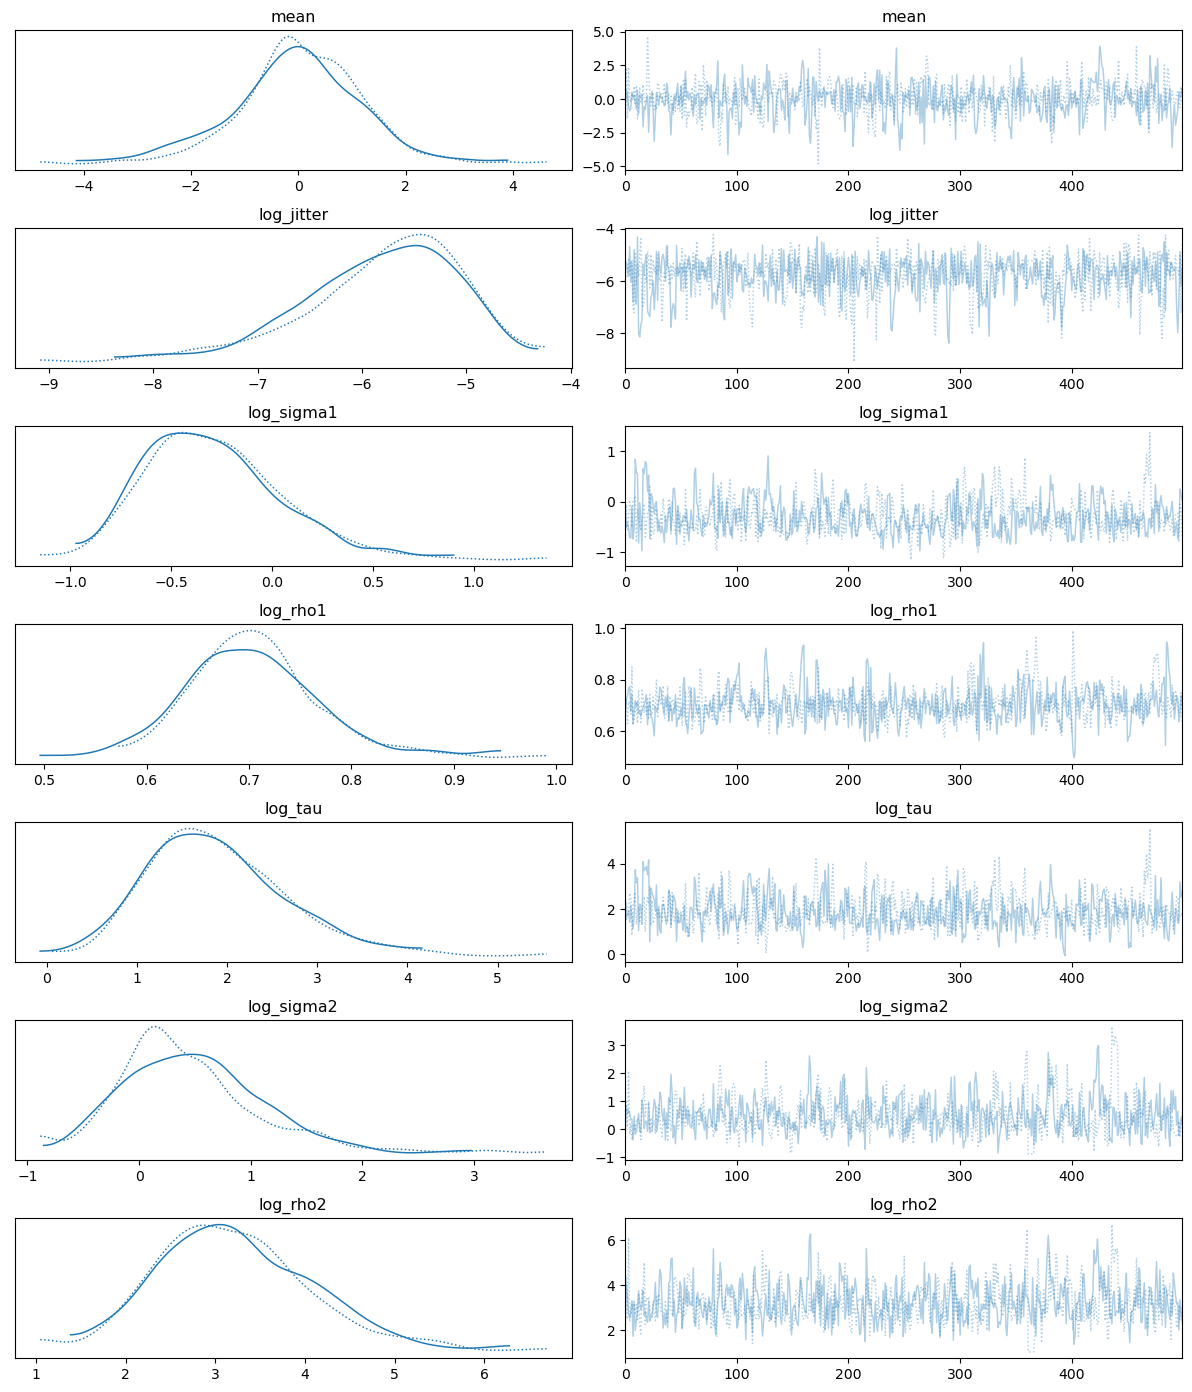

In [18]:
import arviz as az

az.plot_trace(trace,var_names=['mean','log_jitter','log_sigma1','log_rho1','log_tau','log_sigma2','log_rho2']);
plt.tight_layout(pad=1)
plt.show()

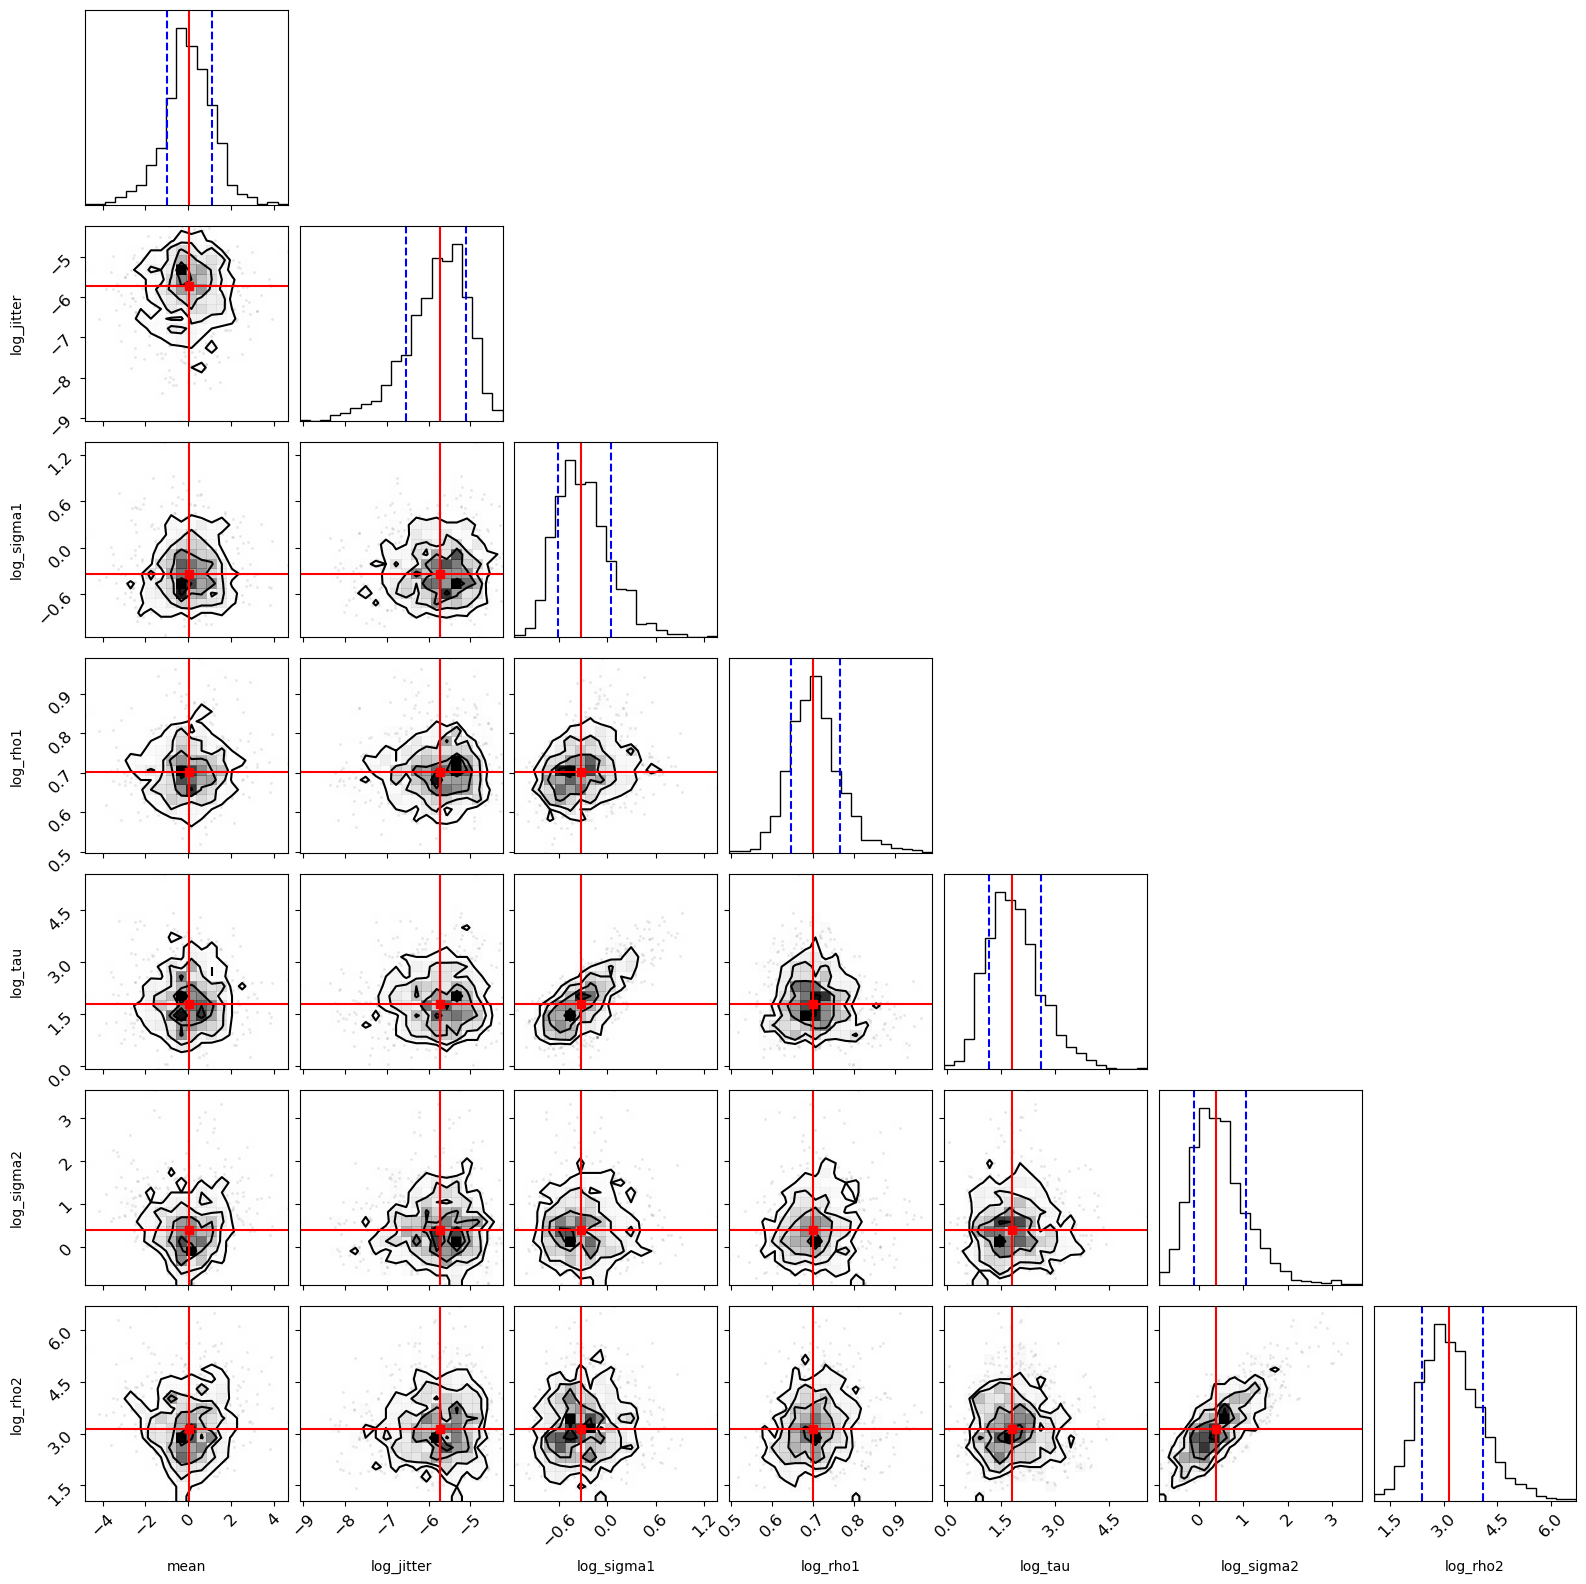

In [19]:
def plot_corner(trace,**kwargs):
    import corner
    var_names=["mean","log_jitter","log_sigma1","log_rho1","log_tau","log_sigma2","log_rho2"]
    ndim = len(var_names)
    
        
    mean_values = []
    for i in range(len(var_names)):
        v = var_names[i]
        trace_samples = np.asarray(trace.posterior[v]).flatten()
        mean_values = np.append(mean_values, np.quantile(trace_samples,q=0.5))    
        
    fig = corner.corner(
        trace, var_names=var_names,\
        truths=dict(zip(var_names, mean_values)),\
        truth_color = 'red')
    
    fig.subplots_adjust(right=1.5,top=1.5)
    # Extract the axes
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(len(var_names)):
        v = var_names[i]
        trace_samples = np.asarray(trace.posterior[v]).flatten()
        # Loop over the diagonal
        ax = axes[i, i]
        ax.axvline(np.quantile(trace_samples,q=0.16), color="b",linestyle='--')
        ax.axvline(np.quantile(trace_samples,q=0.84), color="b",linestyle='--')
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
    fig.tight_layout(pad=0)
    plt.show()
    
plot_corner(trace)

# apply to real data: Daily Sunspot numbers 1850 - 2023

In [20]:
import pandas as pd

data = pd.read_csv('https://www.sidc.be/SILSO/INFO/sndtotcsv.php', sep=';',
                 names=['Year','Month','Day','Decimal Date','Daily Sunspot Number',
                       'Standard Deviation','Number of Observations','Definitive/provisional indicator'])
orig_df = data.loc[data['Daily Sunspot Number']>0].reset_index(drop=True)

# because this is a large data set, let's limit this to be within the last 55 years of observations:

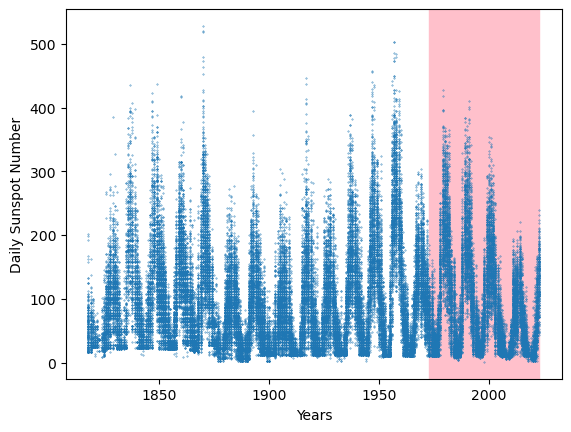

60442
17416


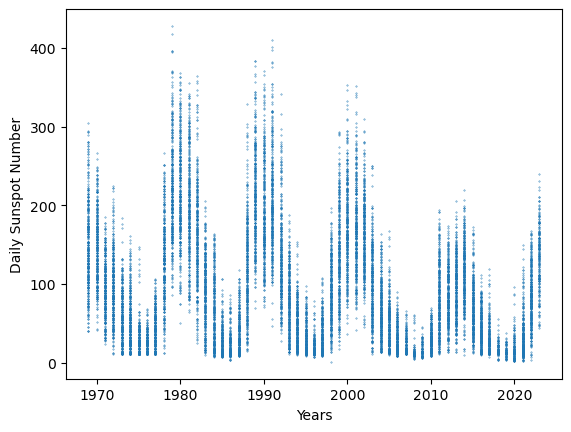

In [21]:
plt.scatter(orig_df['Year'],orig_df['Daily Sunspot Number'],s=0.1)
plt.axvspan(xmin=np.max(orig_df['Year'])-50,xmax=np.max(orig_df['Year']),color='pink',zorder=-10)
plt.xlabel('Years')
plt.ylabel('Daily Sunspot Number')
plt.show()

print(len(orig_df))
last_N_years=55
df = orig_df.loc[orig_df['Year']>np.max(orig_df['Year'])-last_N_years].reset_index(drop=True)
print(len(df))

plt.scatter(df['Year'],df['Daily Sunspot Number'],s=0.1)
plt.xlabel('Years')
plt.ylabel('Daily Sunspot Number')
plt.show()

# this is not a strictly periodic signal, it has varying amplitudes and may suggest quasi-periodic variations. For this reason, in our GP kernel, we'll drop the usage of a stochastically-driven, damped harmonic oscillator (SHO) and will use a "RotationTerm" kernel, which is a mixture of 2 SHO terms.

In [22]:
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess

def GP_model(x,y,yerr,guess_period):
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=np.nanmean(y), sigma=10.0)

        # A jitter term describing excess white noise
        log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

        # A term to describe the non-periodic variability
        sigma = pm.InverseGamma("sigma", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
        rho = pm.InverseGamma("rho", **pmx.estimate_inverse_gamma_parameters(0.5, 2.0))

        # The parameters of the RotationTerm kernel
        sigma_rot = pm.InverseGamma("sigma_rot", **pmx.estimate_inverse_gamma_parameters(1.0, 5.0))
        
        min_period = guess_period-guess_period*0.5
        max_period = guess_period+guess_period*0.5
        log_period = pm.Bound(pm.Normal, lower=np.log(min_period), upper=np.log(max_period))("log_period", mu=np.log(guess_period), sigma=2.0)
        
        period = pm.Deterministic("period", tt.exp(log_period))
        log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
        log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
        f = pm.Uniform("f", lower=0.1, upper=1.0)

        # Set up the Gaussian Process model
        # a single SHO 
        kernal_func1=terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        # a double SHO
        kernal_func2= terms.RotationTerm(sigma=sigma_rot,period=period,
                                         Q0=tt.exp(log_Q0),dQ=tt.exp(log_dQ),
                                         f=f)
        
        # kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
        
        # kernel += terms.RotationTerm(
        #     sigma=sigma_rot,
        #     period=period,
        #     Q0=tt.exp(log_Q0),
        #     dQ=tt.exp(log_dQ),
        #     f=f,
        # )
        
        kernel = kernal_func1 + kernal_func2

        #covariance function sigma^2 + S^2 
        # cov = yerr**2 + tt.exp(2 * log_jitter)       
        cov = yerr**2 + pm.math.exp(2* log_jitter)
        
        gp = GaussianProcess(
            kernel,
            t=x,
            diag=cov,
            mean=mean,
            quiet=True,
        )

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        gp.marginal("gp", observed=y)

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict(y))

        # Optimize to find the maximum a posteriori parameters
        map_soln = pmx.optimize()
    
    return map_soln, model, gp

def get_trace_and_GP_model_and_period(map_soln,model,y,tune,draws,target_accept):
    with model:
        trace = pmx.sample(
            tune=tune,
            draws=draws,
            start=map_soln,
            cores=2,
            chains=2,
            target_accept=target_accept,
            return_inferencedata=True,
            random_seed=[10863087, 10863088],
        )
        
    #Pull mcmc model 
    flat_samps = trace.posterior.stack(sample=("chain","draw"))
    map_model = map_soln['pred']
    mcmc_model = np.percentile(flat_samps['pred'],[16,50,84],axis=-1)
    period_samples = np.asarray(trace.posterior["period"]).flatten()
    mcmc_model = mcmc_model[1]
    resid = y-mcmc_model
    newy=resid
    
    counts, bins = np.histogram(period_samples, bins=int(draws/2), density=True) #why bins=draws/2? Arbitrary choice
    peak_ind = np.argmax(counts) #select period by one with highest posterior density
    gp_period = bins[peak_ind]
    
    return trace, map_model, mcmc_model, newy, gp_period, period_samples



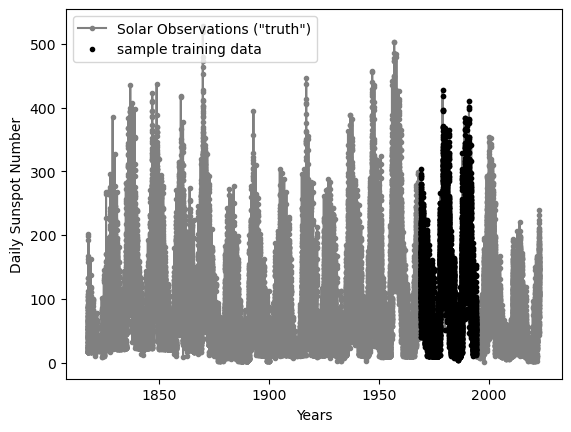

In [23]:
# creating a subsample to train our GP model on

use_half_data=True

if use_half_data==True:
    x = np.array(df['Year'])[0:int(len(df['Year'])/2)]
    y = np.array(df['Daily Sunspot Number'])[0:int(len(df['Year'])/2)]

else: #use only ~ 1/10th
    x = np.array(df['Year'])[0:int(len(df['Year'])/10)]
    y = np.array(df['Daily Sunspot Number'])[0:int(len(df['Year'])/10)]    
yerr = np.ones_like(y)*np.nanstd(y)
# 




true_x = np.array(orig_df['Year'])
true_y = np.array(orig_df['Daily Sunspot Number'])

plt.plot(true_x, true_y,marker='.', label='Solar Observations ("truth")',color='grey')
plt.plot(x, y, 'k.', label='sample training data')

plt.legend()
plt.xlabel('Years')
plt.ylabel('Daily Sunspot Number')
plt.show()

#step 3: create MAP model with GP:
#
tune = 500
draws = 500
target_accept = 0.95


# the process of performing can take a while, depending on how many "draws" from your sample you do and how many "tuning" parameters you use. For this reason, let's time our calculation:

In [24]:
import time as clock
start=clock.time()


guess_period = 11 #years, loose guess from memory of sun's activity cycle
map_soln, model,gp = GP_model(x,y,yerr,guess_period)

#step 4: perform MCMC and get trace
trace, map_model, mcmc_model, newy, gp_period, period_samples = get_trace_and_GP_model_and_period(map_soln,model,y,tune,draws,target_accept)

end=clock.time()


optimizing logp for variables: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


message: Optimization terminated successfully.
logp: -51070.33360392883 -> -47885.853768975925
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [f, log_dQ, log_Q0, log_period, sigma_rot, rho, sigma, log_jitter, mean]


/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/daxfeliz/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 2 chains for 500 tune and 500 draw iterations (1_000 + 1_000 draws total) took 64 seconds.


In [25]:
runtime = end-start
if runtime < 60:
    print(runtime,'seconds')
if (runtime > 60) & (runtime<60*60):
    print(runtime/60,'minutes')    
if (runtime > 60*60):
    print(runtime/60*60,'hours')    

1.1997961322466533 minutes


In [26]:
# use_half_data=True

# if use_half_data==True:
#     x = np.array(df['Year'])[0:int(len(df['Year'])/2)]
#     y = np.array(df['Daily Sunspot Number'])[0:int(len(df['Year'])/2)]

# else: #use only ~ 1/10th
#     x = np.array(df['Year'])[0:int(len(df['Year'])/10)]
#     y = np.array(df['Daily Sunspot Number'])[0:int(len(df['Year'])/10)]    
# yerr = np.ones_like(y)*np.nanstd(y)
# # 
# #step 3: create MAP model with GP:
# #
# tune = 100
# draws = 100
# target_accept = 0.9

# guess_period = 11 #years, loose guess from memory of sun's activity cycle
# # map_soln, model,gp = GP_model(x,y,yerr,guess_period)
# map_soln3, model,gp3 = GP_model3(x,y,yerr,guess_period)


# #step 4: perform MCMC and get trace
# trace3, map_model3,mcmc_model3, mcmc_model, newy, gp_period,period_samples = get_trace_and_GP_model_and_period(map_soln,model,y,tune,draws,target_accept)

In [27]:
map_soln

{'mean': array(110.17479794),
 'log_jitter': array(0.10902726),
 'sigma_log__': array(0.70416888),
 'rho_log__': array(-0.11337547),
 'sigma_rot_log__': array(3.76627528),
 'log_period_interval__': array(0.11796286),
 'log_Q0_log__': array(-1.18818377),
 'log_dQ': array(1.37116646),
 'f_interval__': array(-0.00103055),
 'sigma': array(2.02216533),
 'rho': array(0.89281537),
 'sigma_rot': array(43.21878686),
 'log_period': array(2.28641558),
 'period': array(9.83960514),
 'log_Q0': array(0.3047743),
 'f': array(0.54976813),
 'pred': array([150.13145185, 150.13145185, 150.13145185, ...,  54.50645894,
         54.50645894,  54.50645894])}

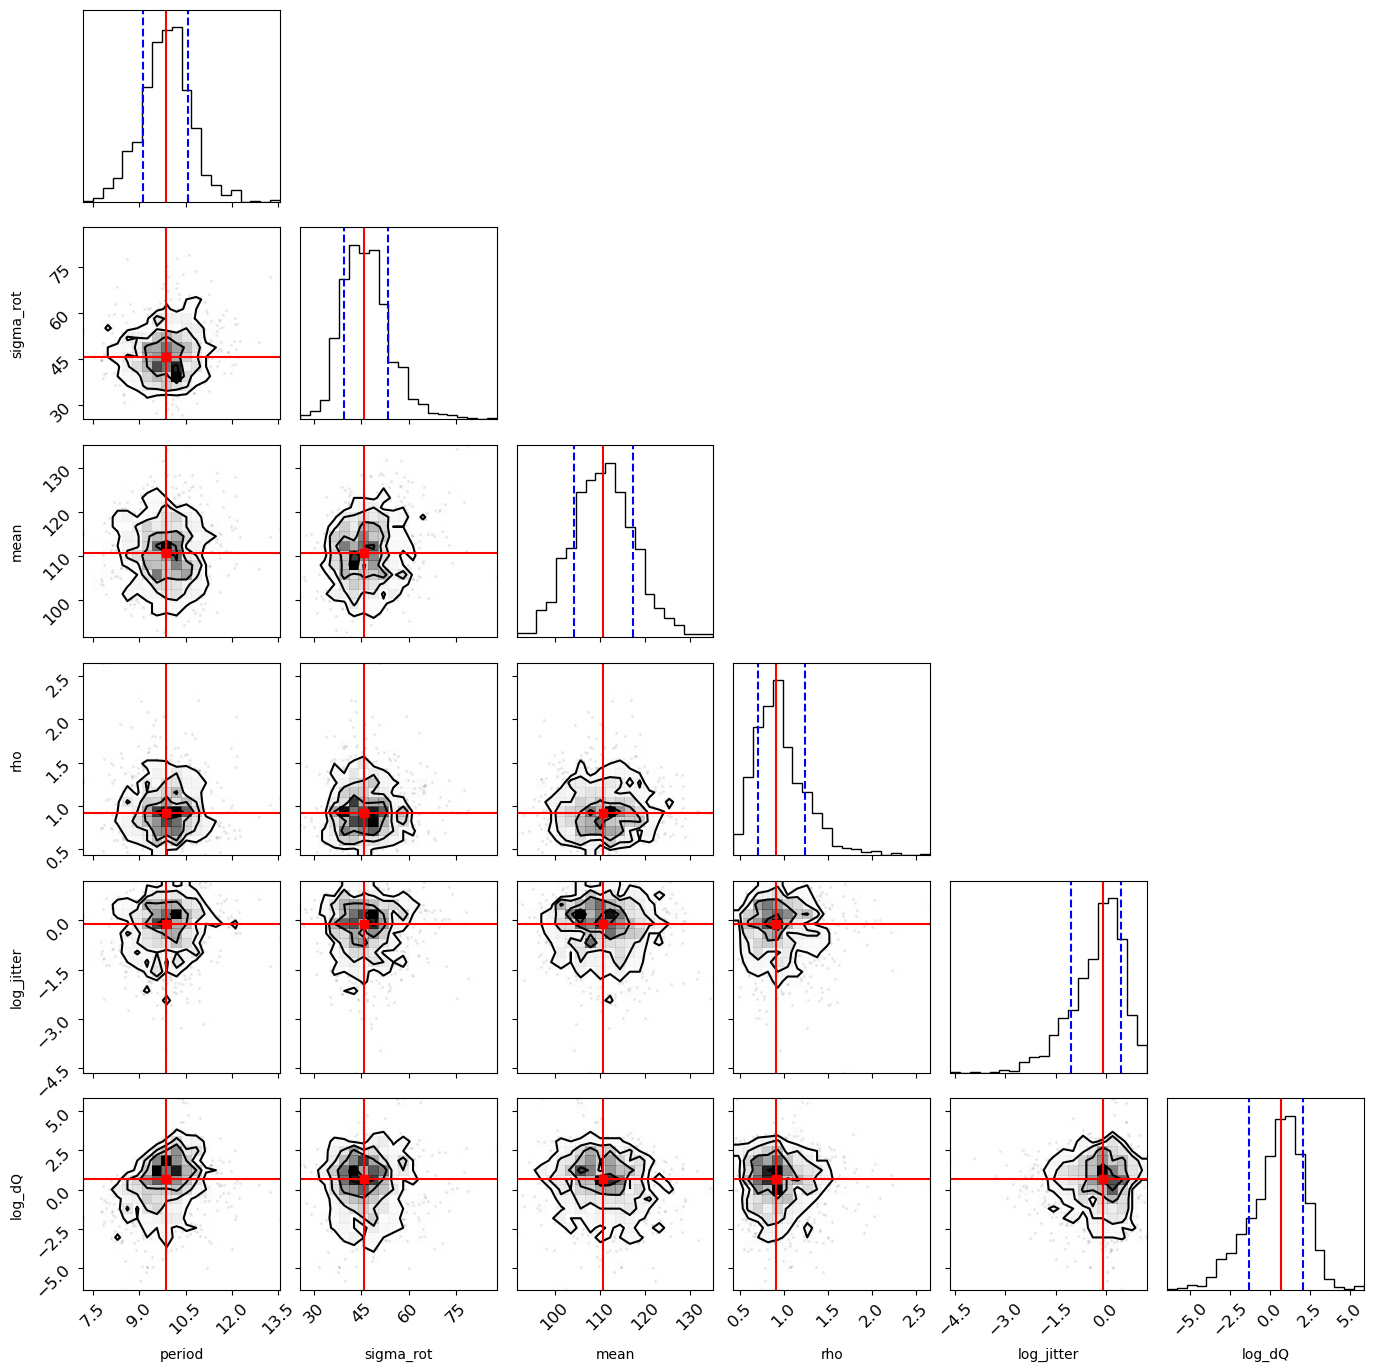

In [28]:
def plot_corner2(trace,**kwargs):
    import corner
    var_names=["period","sigma_rot","mean","rho","log_jitter",'log_dQ']
    ndim = len(var_names)
    
        
    mean_values = []
    for i in range(len(var_names)):
        v = var_names[i]
        trace_samples = np.asarray(trace.posterior[v]).flatten()
        mean_values = np.append(mean_values, np.quantile(trace_samples,q=0.5))    
        
    fig = corner.corner(
        trace, var_names=var_names,\
        truths=dict(zip(var_names, mean_values)),\
        truth_color = 'red')
    
    fig.subplots_adjust(right=1.5,top=1.5)
    # Extract the axes
    axes = np.array(fig.axes).reshape((ndim, ndim))

    for i in range(len(var_names)):
        v = var_names[i]
        trace_samples = np.asarray(trace.posterior[v]).flatten()
        # Loop over the diagonal
        ax = axes[i, i]
        ax.axvline(np.quantile(trace_samples,q=0.16), color="b",linestyle='--')
        ax.axvline(np.quantile(trace_samples,q=0.84), color="b",linestyle='--')
    for ax in fig.get_axes():
        ax.tick_params(axis='both', labelsize=12)
    fig.tight_layout(pad=0)
    plt.show()
plot_corner2(trace)

8708 8708


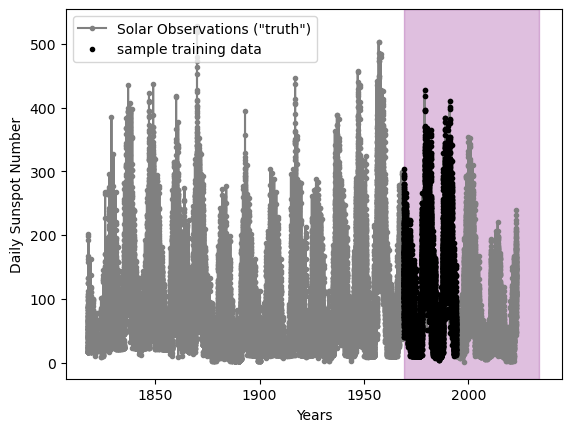

In [29]:
x_new_min = np.min(np.array(df['Year']))
x_new_max = np.max(np.array(orig_df['Year'])) + 11

x_new = np.linspace(x_new_min,x_new_max, len(x))
print(len(x_new),len(x))



true_x = np.array(orig_df['Year'])
true_y = np.array(orig_df['Daily Sunspot Number'])
plt.plot(true_x, true_y,marker='.', label='Solar Observations ("truth")',color='grey')
plt.plot(x, y, 'k.', label='sample training data')
plt.axvspan(xmin=np.min(x_new),xmax=np.max(x_new),color='purple',zorder=-10,alpha=0.25)
plt.legend()
plt.xlabel('Years')
plt.ylabel('Daily Sunspot Number')
plt.show()

In [30]:
# this step can also take a while sometimes, depending on how far out you want to make a prediction

start2=clock.time()
with model:
    mu, var = eval_in_model(gp.predict(y, t=x_new, return_var=True), map_soln)
sd = np.sqrt(var)

end2=clock.time()

runtime2 = end2-start2
if runtime2 < 60:
    print(runtime2,'seconds')
if (runtime2 > 60) & (runtime2 < 60*60):
    print(runtime2/60,'minutes')    
if (runtime2 > 60*60):
    print(runtime2/60*60,'hours')    


38.32556176185608 seconds


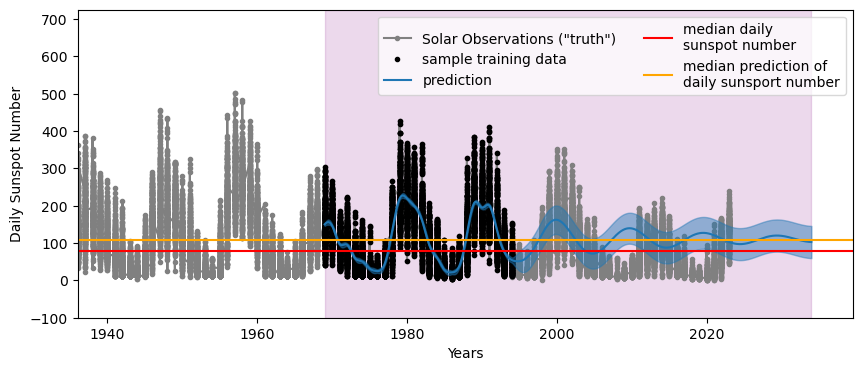

In [31]:
plt.figure(figsize=(10,4))
plt.plot(true_x, true_y,marker='.', label='Solar Observations ("truth")',color='grey',zorder=-1)
plt.plot(x, y, 'k.', label='sample training data',zorder=-1)
plt.axvspan(xmin=np.min(x_new),xmax=np.max(x_new),color='purple',zorder=-10,alpha=0.15)

plt.plot(x_new, mu, label="prediction",zorder=2)
plt.fill_between(x_new, mu - sd, mu + sd, color="C0", alpha=0.45,zorder=1)


plt.xlim(np.min(x_new)-guess_period*3,np.max(x_new)+guess_period*0.5)

plt.axhline(y=np.nanmedian(true_y),color='red',linestyle='-',label='median daily \nsunspot number')
plt.axhline(y=np.nanmedian(mu),color='orange',linestyle='-',label='median prediction of \ndaily sunsport number')
plt.xlabel('Years')
plt.ylabel('Daily Sunspot Number')
plt.ylim(-100,725)
plt.legend(framealpha=0.75,ncol=2)
plt.show()


# Resources for using GPs in Python

In the previous section, we developed a fully-functional GP code that you could now use for research, but it might be better to use an existing software package that makes it easier to try out different models and some other niceties.
There are packages in every programming language but, if you use Python as your programming language of choice, there are a few different software packages that you can use. Here are a few options:

1. [george](https://george.readthedocs.io/en/latest/) – Written (by Dan Foreman-Mackey at Flatiron CCA) with astronomy in mind. Good for general purpose GP modeling.
2. [scikit-learn](http://scikit-learn.org/stable/modules/gaussian_process.html) – Well supported package with a big community. Can be used for astronomy projects with some work.
3. [GPy](http://sheffieldml.github.io/GPy/) – Very flexible with state-of-the-art inference algorithms designed by machine learning researchers.
4. [PyMC](https://www.pymc.io/projects/examples/en/latest/gallery.html#gaussian-processes) – Implementation in the context of Hamiltonian MCMC sampling.
5. [PyStan](https://pystan.readthedocs.io/en/latest/index.html) – Like PyMC, a Hamiltonian MCMC sampler with GP support.
6. [celerite](http://celerite.readthedocs.io/) – Scalable GP likelihood calculations for 1D datasets (e.g. time series).
7. [celerite2](https://celerite2.readthedocs.io/en/latest/) – celerite2 is a re-write of the original celerite project to improve numerical stability and integration with various machine learning frameworks. This implementation includes interfaces in Python and C++, with full support for PyMC (v3 and v4) and JAX.
8. etc. – I'm sure that there are others that I've missed!

# Other Useful Resources:
* https://sandipanweb.wordpress.com/2020/12/08/gaussian-process-regression-with-python/

* [An Introduction to Gaussian Process Regression](https://juanitorduz.github.io/gaussian_process_reg/)
* [PyMC3 Docs: Gaussian Processes](https://docs.pymc.io/Gaussian_Processes.html)
* [PyMC3 Docs Example: CO2 at Mauna Loa](https://docs.pymc.io/notebooks/GP-MaunaLoa.html)
* [Bayesian Analysis with Python (Second edition) - Chapter 7](https://github.com/aloctavodia/BAP/blob/master/code/Chp7/07_Gaussian%20process.ipynb)
* [Statistical Rethinking - Chapter 14](https://xcelab.net/rm/statistical-rethinking/)

# Another useful exercise in forecasting:
[https://juanitorduz.github.io/gp_ts_pymc3/](https://juanitorduz.github.io/gp_ts_pymc3/)